In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss

In [2]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)
device

device(type='cuda', index=0)

In [3]:
df_train = pd.read_csv("leaf-classification/train.csv")
df_test = pd.read_csv("leaf-classification/test.csv")

In [4]:
train_features_tensor = torch.tensor(df_train.drop(columns=["id", "species"]).values).to(dtype=torch.float32).to(device)
test_features_tensor = torch.tensor(df_test.drop(columns=["id"]).values).to(dtype=torch.float32).to(device)

In [5]:
def zero_pad_image(img, target_height, target_width):
    height, width = img.shape[:2]
    pad_bottom = max(0, target_height - height)
    pad_right = max(0, target_width - width)
    return cv2.copyMakeBorder(img, 0, pad_bottom, 0, pad_right, borderType=cv2.BORDER_CONSTANT, value=0)

In [6]:
max_height = 0
max_width = 0
folder = "leaf-classification/images/"
for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder, filename), 0)
    height, width = img.shape[:2]
    if height > max_height:
        max_height = height
    if width > max_width:
        max_width = width

In [7]:
height = max_height // 5
width = max_width // 5

In [8]:
height

217

In [9]:
width

341

In [10]:
df_images_train = np.zeros((1, height, width))
for id in df_train["id"]:
    img = cv2.imread("leaf-classification/images/" + str(id) + ".jpg", 0)
    img = zero_pad_image(img, max_height, max_width)
    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
    df_images_train = np.r_[df_images_train, [img]]
df_images_train = np.delete(df_images_train, (0), axis=0)

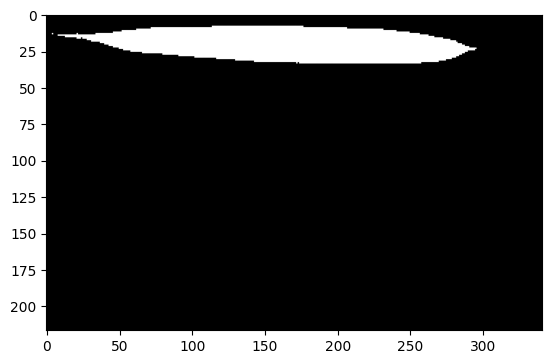

In [11]:
plt.imshow(df_images_train[24], cmap='gray')

In [12]:
df_images_test = np.zeros((1, height, width))
for id in df_test["id"]:
    img = cv2.imread("leaf-classification/images/" + str(id) + ".jpg", 0)
    img = zero_pad_image(img, max_height, max_width)
    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)
    df_images_test = np.r_[df_images_test, [img]]
df_images_test = np.delete(df_images_test, (0), axis=0)

In [13]:
train_images_tensor = torch.tensor(df_images_train).to(dtype=torch.float32).unsqueeze(1).to(device)
test_images_tensor = torch.tensor(df_images_test).to(dtype=torch.float32).unsqueeze(1).to(device)

In [14]:
species_dict = {}
for i, category in enumerate(df_train["species"].unique()):
    species_dict[category] = i

In [15]:
y = df_train["species"].values
y = [species_dict[category] for category in y]

In [16]:
target_tensor = torch.nn.functional.one_hot(torch.tensor(y)).to(dtype=torch.float32).to(device)

In [17]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, features, images, labels):
        self.features = features
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.images[idx], self.labels[idx]

In [18]:
train_ds = CustomDataset(train_features_tensor, train_images_tensor, target_tensor)
test_ds = CustomDataset(test_features_tensor, test_images_tensor, test_features_tensor)

In [19]:
train_ds, val_ds = torch.utils.data.random_split(train_ds, [0.8, 0.2])

In [20]:
mini_batch_size = 32

In [21]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=mini_batch_size, shuffle=True, drop_last=False)
valid_dl = torch.utils.data.DataLoader(val_ds, batch_size=mini_batch_size * 2)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=mini_batch_size * 2)

pure CNN image model

In [22]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_features = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(2), # 217x341 -> 108x170

            nn.Conv2d(10, 20, kernel_size=3, padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(2), # 54x85

            nn.Conv2d(20, 40, kernel_size=3, padding=1),
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.MaxPool2d(2), # 27x42

            nn.Conv2d(40, 80, kernel_size=3, padding=1),
            nn.BatchNorm2d(80),
            nn.ReLU(),
            nn.MaxPool2d(2), # 13x21
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1)) # Output: (batch_size, 80, 1, 1)

        self.classifier = nn.Linear(80, 99)

    def forward(self, X_features, X_images):
        X = self.conv_features(X_images)
        X = self.global_avg_pool(X) # (B, 80, 1, 1)
        X = X.view(X.size(0), -1) # (B, 80)
        return self.classifier(X) # (B, 99)

In [23]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [24]:
CNN_model = CNN().to(device)
optimizer_CNN = torch.optim.Adam(CNN_model.parameters())
early_stopping_CNN = EarlyStopping(patience=20, delta=0.01)

In [25]:
sum(p.numel() for p in CNN_model.parameters() if p.requires_grad)

46359

In [26]:
def fit(model, optimizer, early_stopping, train_dl):
    loss_func = torch.nn.CrossEntropyLoss()

    # loop over epochs
    for epoch in range(500):
        model.train()

        # loop over mini-batches
        for X_features_mb, X_images_mb, y_mb in train_dl:
            y_hat = model(X_features_mb, X_images_mb)

            loss = loss_func(y_hat, y_mb)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            train_loss = sum(loss_func(model(X_features_mb, X_images_mb), y_mb) for X_features_mb, X_images_mb, y_mb in train_dl)
            valid_loss = sum(loss_func(model(X_features_mb, X_images_mb), y_mb) for X_features_mb, X_images_mb, y_mb in valid_dl)
        print('epoch {}, training loss {}'.format(epoch + 1, train_loss / len(train_dl)))
        print('epoch {}, validation loss {}'.format(epoch + 1, valid_loss / len(valid_dl)))

        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

In [27]:
fit(CNN_model, optimizer_CNN, early_stopping_CNN, train_dl)

epoch 1, training loss 4.539726257324219
epoch 1, validation loss 4.551149368286133
epoch 2, training loss 4.456623554229736
epoch 2, validation loss 4.49194860458374
epoch 3, training loss 4.382542133331299
epoch 3, validation loss 4.434602737426758
epoch 4, training loss 4.285975456237793
epoch 4, validation loss 4.360361576080322
epoch 5, training loss 4.21829080581665
epoch 5, validation loss 4.296947956085205
epoch 6, training loss 4.108278751373291
epoch 6, validation loss 4.180332183837891
epoch 7, training loss 4.010843276977539
epoch 7, validation loss 4.105395793914795
epoch 8, training loss 3.8998656272888184
epoch 8, validation loss 4.025290012359619
epoch 9, training loss 3.8643124103546143
epoch 9, validation loss 3.9556233882904053
epoch 10, training loss 3.7549614906311035
epoch 10, validation loss 3.8997068405151367
epoch 11, training loss 3.7103559970855713
epoch 11, validation loss 3.8785722255706787
epoch 12, training loss 3.701502561569214
epoch 12, validation loss

In [28]:
early_stopping_CNN.load_best_model(CNN_model)

In [29]:
with torch.no_grad():
    yhat_train_CNN = CNN_model(train_ds[:][0], train_ds[:][1]).cpu()
    yhat_val_CNN = CNN_model(val_ds[:][0], val_ds[:][1]).cpu()

In [30]:
accuracy_score(np.argmax(train_ds[:][2].cpu().numpy(), axis=1), np.argmax(yhat_train_CNN.numpy(), axis=1))

1.0

In [31]:
accuracy_score(np.argmax(val_ds[:][2].cpu().numpy(), axis=1), np.argmax(yhat_val_CNN.numpy(), axis=1))

0.7525252525252525

In [32]:
softmax = nn.Softmax(dim=1)

In [33]:
log_loss(train_ds[:][2].cpu().numpy(), softmax(yhat_train_CNN).numpy())

0.13478189925467005

In [34]:
log_loss(val_ds[:][2].cpu().numpy(), softmax(yhat_val_CNN).numpy())

0.8825494593849018

pure tabular feature model

In [35]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(192, 1000),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1000, 99)
        )

    def forward(self, X_features, X_images):
        return self.mlp(X_features)

In [36]:
MLP_model = MLP().to(device)
optimizer_MLP = torch.optim.Adam(MLP_model.parameters())
early_stopping_MLP = EarlyStopping(patience=20, delta=0.01)

In [37]:
sum(p.numel() for p in MLP_model.parameters() if p.requires_grad)

292099

In [38]:
fit(MLP_model, optimizer_MLP, early_stopping_MLP, train_dl)

epoch 1, training loss 4.542545318603516
epoch 1, validation loss 4.562008857727051
epoch 2, training loss 4.418935298919678
epoch 2, validation loss 4.491244792938232
epoch 3, training loss 4.177369117736816
epoch 3, validation loss 4.334717750549316
epoch 4, training loss 3.805349588394165
epoch 4, validation loss 4.047629356384277
epoch 5, training loss 3.369678497314453
epoch 5, validation loss 3.6844704151153564
epoch 6, training loss 2.942521572113037
epoch 6, validation loss 3.288233757019043
epoch 7, training loss 2.561784029006958
epoch 7, validation loss 2.93481707572937
epoch 8, training loss 2.2394254207611084
epoch 8, validation loss 2.6005711555480957
epoch 9, training loss 1.9684123992919922
epoch 9, validation loss 2.3196654319763184
epoch 10, training loss 1.7384302616119385
epoch 10, validation loss 2.0887820720672607
epoch 11, training loss 1.533793568611145
epoch 11, validation loss 1.8970177173614502
epoch 12, training loss 1.3663386106491089
epoch 12, validation l

In [39]:
early_stopping_MLP.load_best_model(MLP_model)

In [40]:
with torch.no_grad():
    yhat_train_MLP = MLP_model(train_ds[:][0], train_ds[:][1]).cpu()
    yhat_val_MLP = MLP_model(val_ds[:][0], val_ds[:][1]).cpu()
    yhat_test_MLP = MLP_model(test_ds[:][0], test_ds[:][1]).cpu()

In [41]:
accuracy_score(np.argmax(train_ds[:][2].cpu().numpy(), axis=1), np.argmax(yhat_train_MLP.numpy(), axis=1))

1.0

In [42]:
accuracy_score(np.argmax(val_ds[:][2].cpu().numpy(), axis=1), np.argmax(yhat_val_MLP.numpy(), axis=1))

0.9393939393939394

In [43]:
log_loss(train_ds[:][2].cpu().numpy(), softmax(yhat_train_MLP).numpy())

0.008633193488599257

In [44]:
log_loss(val_ds[:][2].cpu().numpy(), softmax(yhat_val_MLP).numpy())

0.1777902196292474

In [45]:
yhat_proba =  softmax(yhat_test_MLP).cpu().numpy()

In [46]:
submission = pd.DataFrame({"id": df_test["id"]})
for i, col in enumerate(species_dict):
    submission[col] = yhat_proba[:, i]

In [47]:
submission

,id,Acer_Opalus,Pterocarya_Stenoptera,Quercus_Hartwissiana,Tilia_Tomentosa,Quercus_Variabilis,Magnolia_Salicifolia,Quercus_Canariensis,Quercus_Rubra,Quercus_Brantii,...,Quercus_Ellipsoidalis,Quercus_x_Hispanica,Quercus_Shumardii,Quercus_Rhysophylla,Castanea_Sativa,Ulmus_Bergmanniana,Quercus_Nigra,Salix_Intergra,Quercus_Infectoria_sub,Sorbus_Aria
0,4,6.361982e-03,4.016676e-10,2.421585e-05,1.368678e-08,1.479956e-04,1.040618e-12,8.254589e-07,2.220429e-10,2.474605e-08,...,3.003832e-11,1.927282e-09,2.451025e-05,4.121697e-10,7.212481e-07,5.548155e-15,6.459728e-09,3.835895e-06,2.463378e-08,3.665060e-10
1,7,1.301334e-04,6.906714e-10,4.123468e-08,5.320414e-07,5.767550e-07,1.196758e-13,1.596153e-04,4.922698e-08,1.087717e-03,...,2.760711e-07,4.421512e-06,3.353547e-04,3.099251e-08,5.871626e-04,8.378527e-14,2.127101e-09,1.529432e-08,3.138229e-06,4.646349e-11
2,9,9.287945e-09,1.479100e-08,2.804119e-09,5.018440e-08,1.311132e-08,6.575479e-14,1.481681e-11,2.170891e-07,5.969632e-13,...,1.225075e-13,1.234117e-12,6.905336e-09,4.454913e-11,8.857260e-06,7.722358e-10,2.479445e-13,1.536442e-14,2.207425e-15,8.024248e-12
3,12,5.381812e-08,1.069792e-08,3.510939e-09,4.072363e-04,3.977952e-09,5.158402e-19,1.404976e-09,3.941071e-07,1.464042e-07,...,8.625018e-11,1.530005e-09,1.300713e-03,2.612810e-06,9.586835e-01,7.046156e-04,5.250516e-13,3.825633e-16,5.013487e-14,4.047999e-06
4,13,1.192164e-11,8.139600e-07,5.397243e-15,1.696327e-06,1.147967e-12,1.332304e-22,7.465708e-16,3.993999e-10,1.613473e-13,...,1.082685e-12,1.028497e-12,1.368509e-05,1.077192e-06,2.398394e-08,5.309187e-04,3.190063e-14,1.362169e-19,1.064405e-20,4.341741e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,1576,1.681604e-08,3.696166e-08,2.310651e-08,5.331329e-08,2.390784e-08,5.583567e-14,1.950390e-11,6.901726e-08,9.876775e-14,...,5.085784e-15,7.687908e-13,4.684758e-09,3.484495e-11,3.551190e-06,4.331296e-09,4.764507e-13,3.349187e-14,2.197538e-15,1.013948e-10
590,1577,2.102839e-05,7.496149e-09,3.564399e-07,1.440784e-04,1.080863e-08,3.971778e-20,5.368395e-09,1.479390e-11,1.696066e-05,...,2.846138e-14,1.341914e-08,3.872281e-06,1.565305e-09,1.997586e-04,3.091264e-06,2.020453e-13,5.136497e-14,1.480529e-12,3.013389e-06
591,1579,1.584144e-07,4.760495e-10,7.487570e-03,4.252689e-13,4.427911e-06,1.134169e-12,9.859234e-01,8.904309e-08,7.816122e-09,...,1.036749e-14,1.932826e-09,1.378611e-07,6.939472e-12,3.383562e-06,1.893239e-15,2.399333e-05,3.327832e-11,5.787322e-07,2.525150e-12
592,1580,1.048347e-06,1.221208e-04,7.740957e-12,1.065942e-06,4.592938e-09,9.261630e-14,4.466107e-11,5.778676e-12,3.527055e-12,...,2.139064e-07,1.386637e-04,1.439264e-07,4.091758e-09,5.296275e-07,3.696723e-12,1.138445e-12,5.686945e-06,8.437240e-05,1.642301e-13


In [48]:
submission.to_csv("submission.csv", index=False)

combined model

In [49]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.base_model = CNN_model
        self.base_model.classifier = nn.Identity()
        self.combined_classifier = nn.Sequential(
            nn.Linear(80 + 192, 1000),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1000, 99)
        )

    def forward(self, X_features, X_images):
        extracted_features = self.base_model(X_features, X_images)
        X = torch.cat([X_features, extracted_features], dim=1)
        return self.combined_classifier(X)

In [50]:
combined_model = CombinedModel().to(device)

In [51]:
for param in combined_model.parameters():
    param.requires_grad = False

for param in combined_model.combined_classifier.parameters():
    param.requires_grad = True

In [52]:
sum(p.numel() for p in combined_model.parameters() if p.requires_grad)

372099

In [53]:
optimizer_combined = torch.optim.Adam(combined_model.parameters())
early_stopping_combined = EarlyStopping(patience=20, delta=0.01)

In [54]:
fit(combined_model, optimizer_combined, early_stopping_combined, train_dl)

epoch 1, training loss 3.6169281005859375
epoch 1, validation loss 3.7673757076263428
epoch 2, training loss 2.4815635681152344
epoch 2, validation loss 2.907327175140381
epoch 3, training loss 1.736557126045227
epoch 3, validation loss 2.1407759189605713
epoch 4, training loss 1.265899896621704
epoch 4, validation loss 1.6006829738616943
epoch 5, training loss 0.9549893736839294
epoch 5, validation loss 1.3501434326171875
epoch 6, training loss 0.6632809042930603
epoch 6, validation loss 1.1667319536209106
epoch 7, training loss 0.46858328580856323
epoch 7, validation loss 1.03163480758667
epoch 8, training loss 0.4070398509502411
epoch 8, validation loss 1.0581636428833008
epoch 9, training loss 0.3029974400997162
epoch 9, validation loss 0.9669012427330017
epoch 10, training loss 0.22423982620239258
epoch 10, validation loss 0.8072777986526489
epoch 11, training loss 0.1788627803325653
epoch 11, validation loss 0.7867687344551086
epoch 12, training loss 0.14896728098392487
epoch 12,

In [55]:
early_stopping_combined.load_best_model(combined_model)

In [56]:
with torch.no_grad():
    yhat_train_combined = combined_model(train_ds[:][0], train_ds[:][1]).cpu()
    yhat_val_combined = combined_model(val_ds[:][0], val_ds[:][1]).cpu()

In [57]:
accuracy_score(np.argmax(train_ds[:][2].cpu().numpy(), axis=1), np.argmax(yhat_train_combined.numpy(), axis=1))

1.0

In [58]:
accuracy_score(np.argmax(val_ds[:][2].cpu().numpy(), axis=1), np.argmax(yhat_val_combined.numpy(), axis=1))

0.8333333333333334

In [59]:
log_loss(train_ds[:][2].cpu().numpy(), softmax(yhat_train_combined).numpy())

0.0031220655507029614

In [60]:
log_loss(val_ds[:][2].cpu().numpy(), softmax(yhat_val_combined).numpy())

0.6824222299525275